In [1]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle
import copy

def crossvalidate(reps, labels, tr_size, sigma, lam, num_cv):
    errors = []
    for cv in range(num_cv):
        reps_tr, reps_test, labels_tr, labels_test = sk.train_test_split(reps,labels,train_size=tr_size)
        coeffs = qmi.train_kernel(reps_tr, labels_tr, sigma, lam_val)
        labels_predicted = qmi.predict_labels(reps_test, reps_tr, sigma, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())
    errors = np.array(errors)
    return(errors.mean(), errors.std())

def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def scale_nuclear_charges(data, scaling_factor):
    for d in data:
        d[:,0] = d[:,0]*scaling_factor
    return(data)

def get_weighted_rep(data, molecule_size, scaling_factors):
    all_local_reps = 0
    for sclf in scaling_factors:
        cp = copy.deepcopy(data)
        data_copy = scale_nuclear_charges(cp, sclf)
        weighted_tmp = qmi.generate_atomic_representations(data_copy, molecule_size)
        all_local_reps += weighted_tmp
    return(all_local_reps/len(scaling_factors))
    

In [2]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
alch_pots = qmi.generate_label_vector(data, molecule_size.sum(), value='atomic')
# alch_pots = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')

#all_local_reps = qmi.generate_atomic_representations(data, molecule_size)

lam_vals = np.array([0, 8, 15, 23, 30, 38])/38
all_local_reps = get_weighted_rep(data, molecule_size, lam_vals)

In [3]:
sigmas = np.logspace(-1, 10, 11, base=2)
lam_val = 1e-5
num_cv = 3

lcurves = dict()

# define number of training points for which MAE is calculated
set_sizes = np.logspace(0, 12, 13, base=2).astype(int)

for sigma in sigmas:
    error_cv = []
    error_std = []
    # calculate error for every training point size
    for idx, tr_size in enumerate(set_sizes):
        err, err_std = crossvalidate(all_local_reps, alch_pots, tr_size, sigma, lam_val, num_cv)
        error_cv.append(err)
        error_std.append(err_std)
    
    lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T

### Alchemical potential

In [4]:
# save best learning curve
lowest_error = (None, None)
for k in lcurves.keys():
    if lowest_error[1]==None or lowest_error[1] > np.amin(lcurves[k][:,1]):
        lowest_error = (k, np.amin(lcurves[k][:,1]))
save_data = lcurves[lowest_error[0]]
path = '/home/misa/projects/Atomic-Energies/data/lcurves/alchpot/best_all_alchpots_cm_weighted.txt'
sig_val = lowest_error[0].split('_')[1]
header = f'sigma = {sig_val}, lambda = {lam_val}, number cv = {num_cv}'
np.savetxt(path, save_data, delimiter='\t', header=header)

In [5]:
# save dictionary of learning curves at all sigmas
fname = '/home/misa/projects/Atomic-Energies/data/lcurves/alchpot/all_sigma_all_alchpots_cm_weighted.txt'
save_obj(lcurves, fname)

### Atomic Energy

In [4]:
# save best learning curve
lowest_error = (None, None)
for k in lcurves.keys():
    if lowest_error[1]==None or lowest_error[1] > np.amin(lcurves[k][:,1]):
        lowest_error = (k, np.amin(lcurves[k][:,1]))
save_data = lcurves[lowest_error[0]]
path = '/home/misa/projects/Atomic-Energies/data/lcurves/atomic/best_all_atomic_cm_weighted.txt'
sig_val = lowest_error[0].split('_')[1]
header = f'sigma = {sig_val}, lambda = {lam_val}, number cv = {num_cv}'
np.savetxt(path, save_data, delimiter='\t', header=header)

# save dictionary of learning curves at all sigmas
fname = '/home/misa/projects/Atomic-Energies/data/lcurves/atomic/all_sigma_all_atomic_cm_weighted.txt'
save_obj(lcurves, fname)

# Plots

In [6]:
from matplotlib import pyplot as plt

### Alchemical potential

In [19]:
normal_cm = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_all_alchpots.txt')
weighted_cm = np.loadtxt('/home/misa/projects/Atomic-Energies/data/lcurves/alchpot/best_all_alchpots_cm_weighted.txt')

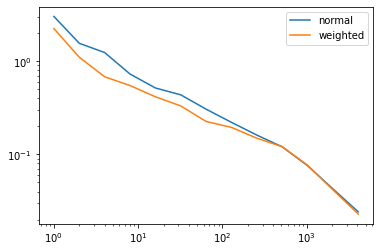

In [20]:
plt.plot(normal_cm[:,0], normal_cm[:,1], label= 'normal')
plt.plot(weighted_cm[:,0], weighted_cm[:,1], label= 'weighted')
plt.xscale('log')
plt.yscale('log')
plt.legend()

### Atomic Energy

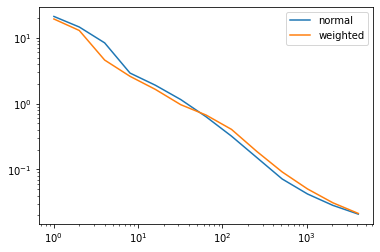

In [7]:
normal_cm = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_atomic/cm/best_all_atomic.txt')
weighted_cm = np.loadtxt('/home/misa/projects/Atomic-Energies/data/lcurves/atomic/best_all_atomic_cm_weighted.txt')
plt.plot(normal_cm[:,0], normal_cm[:,1], label= 'normal')
plt.plot(weighted_cm[:,0], weighted_cm[:,1], label= 'weighted')
plt.xscale('log')
plt.yscale('log')
plt.legend()